Implementing a seq-to-seq network for a simple prediction task and show improvement comparison RNN, LSTM and GRU.

In [44]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense
import matplotlib.pyplot as plt
import random
import string
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import numpy as np


In [45]:

vocab = ["<pad>"] + list(string.ascii_lowercase)
vocab_size = len(vocab)
char_to_idx = {c: i for i, c in enumerate(vocab)}
idx_to_char = {i: c for c, i in char_to_idx.items()}
print("Vocabulary mapping:", idx_to_char)

def shift_letter(char, shift_by):
    if char == '<pad>': # Handle padding character
        return '<pad>'
    return chr((ord(char) - ord("a") + shift_by) % 26 + ord("a"))

def generate_sample(n=5000, max_len=26, min_shift=3, max_shift=4):
    x_data, y_data = [], []
    for _ in range(n):
        word_len = random.randint(1, max_len)
        word = "".join(random.choices(string.ascii_lowercase, k=word_len))
        
        current_shift_amount = random.randint(min_shift, max_shift)

        shifted = "".join(shift_letter(c, current_shift_amount) for c in word)
        
        x_data.append([char_to_idx[c] for c in word])
        y_data.append([char_to_idx[c] for c in shifted])
    return x_data, y_data


Vocabulary mapping: {0: '<pad>', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [46]:

def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.suptitle(title)

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    if 'val_accuracy' in history.history:
        plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    if 'val_loss' in history.history:
        plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()


In [47]:

MAX_SEQUENCE_LENGTH = 26 
NUM_SAMPLES = 20000 
MIN_SHIFT_AMT = 3
MAX_SHIFT_AMT = 4

x_data_raw, y_data_raw = generate_sample(n=NUM_SAMPLES, max_len=MAX_SEQUENCE_LENGTH, 
                                         min_shift=MIN_SHIFT_AMT, max_shift=MAX_SHIFT_AMT)

x_padded = pad_sequences(x_data_raw, maxlen=MAX_SEQUENCE_LENGTH, padding="post", value=char_to_idx["<pad>"])
y_padded = pad_sequences(y_data_raw, maxlen=MAX_SEQUENCE_LENGTH, padding="post", value=char_to_idx["<pad>"])
x_train, x_test, y_train, y_test = train_test_split(x_padded, y_padded, test_size=0.2, random_state=42)

Callbacks

In [48]:

early_stop = EarlyStopping(monitor="val_accuracy", patience=7, restore_best_weights=True, mode='max', verbose=1) 
lr_schedule = ReduceLROnPlateau(
    monitor='val_loss',    
    factor=0.5,
    patience=4,
    min_lr=1e-6,
    verbose=1
)


In [49]:

print(f"\nTraining data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")



Training data shape: (16000, 26)
Test data shape: (4000, 26)


Training RNN

In [50]:

print("\n--- Training SimpleRNN Model ---")
rnn_model = Sequential(
    [
        Embedding(input_dim=vocab_size, output_dim=32, input_length=MAX_SEQUENCE_LENGTH),
        SimpleRNN(64, return_sequences=True), 
        Dense(vocab_size, activation="softmax"), 
    ])
rnn_model.compile(
    optimizer="adam", 
    loss="sparse_categorical_crossentropy", 
    metrics=["accuracy"]
)
rnn_history = rnn_model.fit(
    x_train, y_train, 
    epochs=100, 
    batch_size=128, 
    validation_split=0.2, 
    callbacks=[early_stop, lr_schedule],
    verbose=2 
)

rnn_loss, rnn_accuracy = rnn_model.evaluate(x_test, y_test, verbose=0)
print(f"SimpleRNN Test Loss: {rnn_loss:.4f}, Test Accuracy: {rnn_accuracy:.4f}")



--- Training SimpleRNN Model ---
Epoch 1/100
100/100 - 2s - 22ms/step - accuracy: 0.6106 - loss: 1.6335 - val_accuracy: 0.7240 - val_loss: 1.1518 - learning_rate: 1.0000e-03
Epoch 2/100
100/100 - 1s - 9ms/step - accuracy: 0.7390 - loss: 0.6820 - val_accuracy: 0.7382 - val_loss: 0.4434 - learning_rate: 1.0000e-03
Epoch 3/100
100/100 - 1s - 9ms/step - accuracy: 0.7418 - loss: 0.4047 - val_accuracy: 0.7374 - val_loss: 0.3914 - learning_rate: 1.0000e-03
Epoch 4/100
100/100 - 1s - 8ms/step - accuracy: 0.7433 - loss: 0.3802 - val_accuracy: 0.7380 - val_loss: 0.3802 - learning_rate: 1.0000e-03
Epoch 5/100
100/100 - 1s - 8ms/step - accuracy: 0.7439 - loss: 0.3728 - val_accuracy: 0.7380 - val_loss: 0.3754 - learning_rate: 1.0000e-03
Epoch 6/100
100/100 - 1s - 8ms/step - accuracy: 0.7453 - loss: 0.3692 - val_accuracy: 0.7383 - val_loss: 0.3729 - learning_rate: 1.0000e-03
Epoch 7/100
100/100 - 1s - 8ms/step - accuracy: 0.7461 - loss: 0.3670 - val_accuracy: 0.7377 - val_loss: 0.3713 - learning_ra

Training LSTM

In [51]:

print("\n--- Training LSTM Model ---")
lstm_model = Sequential(
    [
        Embedding(input_dim=vocab_size, output_dim=32, input_length=MAX_SEQUENCE_LENGTH),
        LSTM(64, return_sequences=True),
        Dense(vocab_size, activation="softmax"),
    ])
lstm_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
lstm_history = lstm_model.fit(
    x_train, y_train, 
    epochs=100, 
    batch_size=128, 
    validation_split=0.2, 
    callbacks=[early_stop, lr_schedule],
    verbose=2
)

lstm_loss, lstm_accuracy = lstm_model.evaluate(x_test, y_test, verbose=0)
print(f"LSTM Test Loss: {lstm_loss:.4f}, Test Accuracy: {lstm_accuracy:.4f}")


--- Training LSTM Model ---
Epoch 1/100
100/100 - 4s - 39ms/step - accuracy: 0.5525 - loss: 1.8847 - val_accuracy: 0.6268 - val_loss: 1.6540 - learning_rate: 1.0000e-03
Epoch 2/100
100/100 - 3s - 27ms/step - accuracy: 0.6661 - loss: 1.3795 - val_accuracy: 0.7334 - val_loss: 0.8712 - learning_rate: 1.0000e-03
Epoch 3/100
100/100 - 2s - 25ms/step - accuracy: 0.7410 - loss: 0.5348 - val_accuracy: 0.7394 - val_loss: 0.4147 - learning_rate: 1.0000e-03
Epoch 4/100
100/100 - 3s - 27ms/step - accuracy: 0.7419 - loss: 0.3928 - val_accuracy: 0.7386 - val_loss: 0.3850 - learning_rate: 1.0000e-03
Epoch 5/100
100/100 - 2s - 24ms/step - accuracy: 0.7431 - loss: 0.3769 - val_accuracy: 0.7395 - val_loss: 0.3767 - learning_rate: 1.0000e-03
Epoch 6/100
100/100 - 3s - 34ms/step - accuracy: 0.7438 - loss: 0.3712 - val_accuracy: 0.7404 - val_loss: 0.3730 - learning_rate: 1.0000e-03
Epoch 7/100
100/100 - 3s - 28ms/step - accuracy: 0.7455 - loss: 0.3682 - val_accuracy: 0.7412 - val_loss: 0.3709 - learning_r

Training GRU

In [52]:
print("\n--- Training GRU Model ---")
gru_model = Sequential(
    [
        Embedding(input_dim=vocab_size, output_dim=32, input_length=MAX_SEQUENCE_LENGTH),
        GRU(64, return_sequences=True), 
        Dense(vocab_size, activation="softmax"),
    ])
gru_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
gru_history = gru_model.fit(
    x_train, y_train, 
    epochs=100, 
    batch_size=128, 
    validation_split=0.2, 
    callbacks=[early_stop, lr_schedule],
    verbose=2
)

gru_loss, gru_accuracy = gru_model.evaluate(x_test, y_test, verbose=0)
print(f"GRU Test Loss: {gru_loss:.4f}, Test Accuracy: {gru_accuracy:.4f}")



--- Training GRU Model ---
Epoch 1/100
100/100 - 4s - 40ms/step - accuracy: 0.6257 - loss: 1.6338 - val_accuracy: 0.7332 - val_loss: 1.0328 - learning_rate: 1.0000e-03
Epoch 2/100
100/100 - 2s - 24ms/step - accuracy: 0.7396 - loss: 0.5675 - val_accuracy: 0.7381 - val_loss: 0.4058 - learning_rate: 1.0000e-03
Epoch 3/100
100/100 - 4s - 37ms/step - accuracy: 0.7413 - loss: 0.3866 - val_accuracy: 0.7390 - val_loss: 0.3804 - learning_rate: 1.0000e-03
Epoch 4/100
100/100 - 4s - 41ms/step - accuracy: 0.7420 - loss: 0.3735 - val_accuracy: 0.7391 - val_loss: 0.3738 - learning_rate: 1.0000e-03
Epoch 5/100
100/100 - 6s - 57ms/step - accuracy: 0.7430 - loss: 0.3690 - val_accuracy: 0.7392 - val_loss: 0.3710 - learning_rate: 1.0000e-03
Epoch 6/100
100/100 - 4s - 36ms/step - accuracy: 0.7438 - loss: 0.3668 - val_accuracy: 0.7392 - val_loss: 0.3694 - learning_rate: 1.0000e-03
Epoch 7/100
100/100 - 4s - 43ms/step - accuracy: 0.7444 - loss: 0.3654 - val_accuracy: 0.7392 - val_loss: 0.3684 - learning_ra

Plotting the graphs and Example Prediction

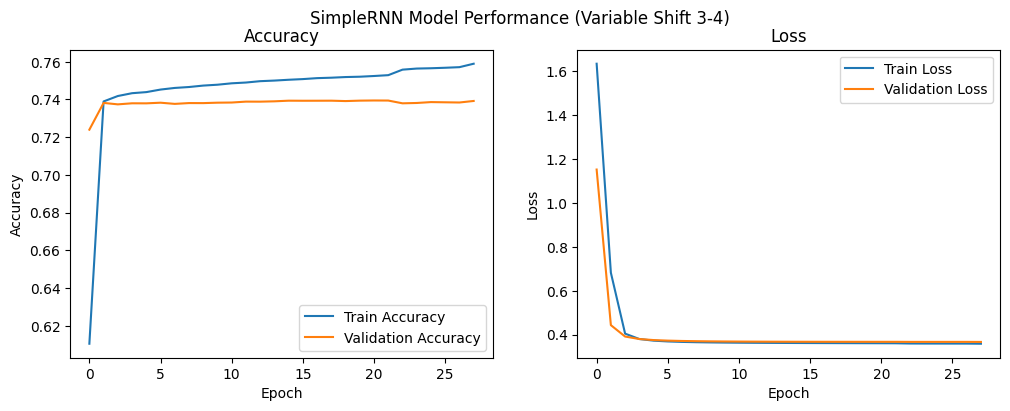

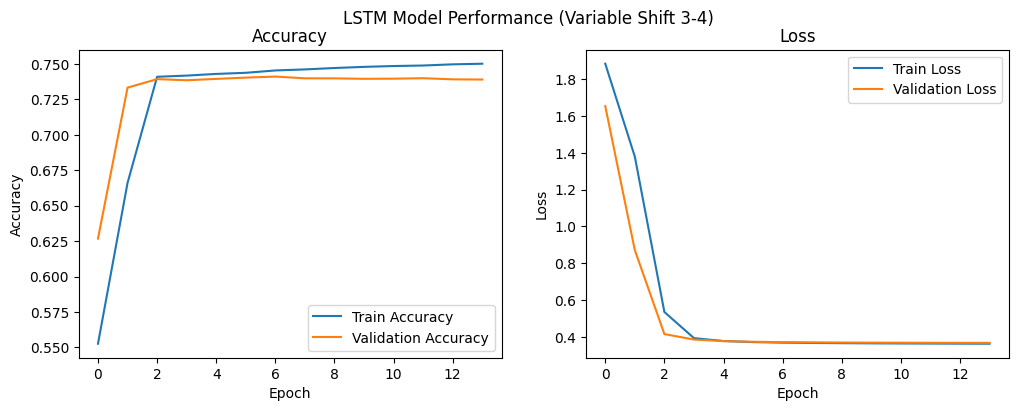

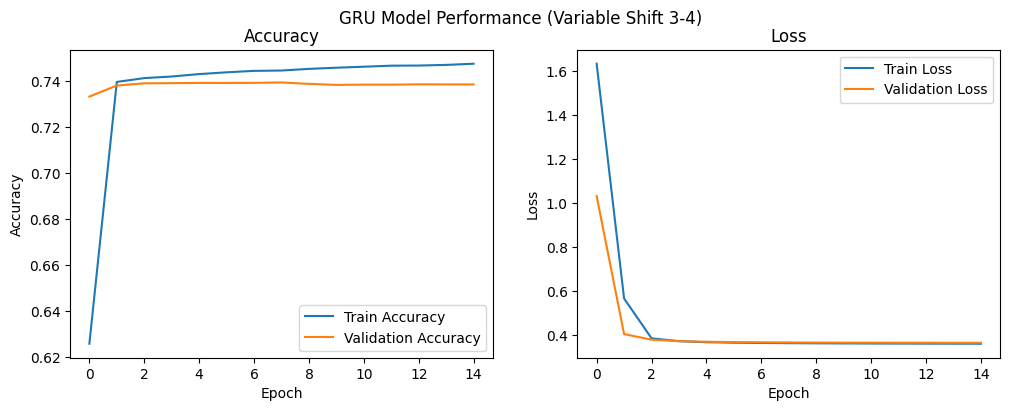


--- Evaluation on Test Data ---

--- Example Predictions (Variable Shift 3-4) ---

Input: 'abcde'
Possible Expected (Shift 3): 'defgh'
Possible Expected (Shift 4): 'efghi'
  RNN Predicted: 'dfggh'
  LSTM Predicted: 'defgh'
  GRU Predicted: 'defhh'
------------------------------

Input: 'hello'
Possible Expected (Shift 3): 'khoor'
Possible Expected (Shift 4): 'lipps'
  RNN Predicted: 'khoos'
  LSTM Predicted: 'lhops'
  GRU Predicted: 'lhppr'
------------------------------

Input: 'python'
Possible Expected (Shift 3): 'sbwkrq'
Possible Expected (Shift 4): 'tcxlsr'
  RNN Predicted: 'sbwkrq'
  LSTM Predicted: 'scxlsq'
  GRU Predicted: 'scxksq'
------------------------------

Input: 'neuralnetwork'
Possible Expected (Shift 3): 'qhxudoqhwzrun'
Possible Expected (Shift 4): 'riyveprixasvo'
  RNN Predicted: 'qhyudpqhwarun'
  LSTM Predicted: 'riyvdoqhwzsun'
  GRU Predicted: 'qhxudoqhwasun'
------------------------------

Input: 'qwertyuiopasdfghjklzxcvbnm'
Possible Expected (Shift 3): 'tzhuwbxl

In [54]:

plot_history(rnn_history, "SimpleRNN Model Performance (Variable Shift 3-4)")
plot_history(lstm_history, "LSTM Model Performance (Variable Shift 3-4)")
plot_history(gru_history, "GRU Model Performance (Variable Shift 3-4)")

print("\n--- Evaluation on Test Data ---")


# Example Predictions
def predict_sequence(model, input_text, max_len, char_to_idx, idx_to_char):
    input_indices = [char_to_idx[c] for c in input_text]
    padded_input = pad_sequences([input_indices], maxlen=max_len, padding="post", value=char_to_idx["<pad>"])
    
    predictions = model.predict(padded_input, verbose=0)
    predicted_indices = np.argmax(predictions, axis=-1)[0]
    
    predicted_chars = [idx_to_char[idx] for idx in predicted_indices[:len(input_text)]] 
    return "".join(predicted_chars)

print("\n--- Example Predictions (Variable Shift 3-4) ---")


def calculate_possible_shifts(input_text, char_to_idx, idx_to_char):
    possible_outputs = {}
    for s in range(26): # Try all possible shifts from 0 to 25
        shifted_text = "".join(shift_letter(c, s) for c in input_text)
        possible_outputs[s] = shifted_text
    return possible_outputs

test_cases = ["abcde", "hello", "python", "neuralnetwork", "qwertyuiopasdfghjklzxcvbnm", "az"]

for text in test_cases:
    
    rnn_predicted = predict_sequence(rnn_model, text, MAX_SEQUENCE_LENGTH, char_to_idx, idx_to_char)
    lstm_predicted = predict_sequence(lstm_model, text, MAX_SEQUENCE_LENGTH, char_to_idx, idx_to_char)
    gru_predicted = predict_sequence(gru_model, text, MAX_SEQUENCE_LENGTH, char_to_idx, idx_to_char)
    
    expected_shift_3 = "".join(shift_letter(c, 3) for c in text)
    expected_shift_4 = "".join(shift_letter(c, 4) for c in text)

    print(f"\nInput: '{text}'")
    print(f"Possible Expected (Shift 3): '{expected_shift_3}'")
    print(f"Possible Expected (Shift 4): '{expected_shift_4}'")

    print(f"  RNN Predicted: '{rnn_predicted}'")
    print(f"  LSTM Predicted: '{lstm_predicted}'")
    print(f"  GRU Predicted: '{gru_predicted}'")
    print("-" * 30)

Summary of the file:

**Objective:** 

Implement sequence-to-sequence models (SimpleRNN, LSTM, GRU) to predict character sequences shifted by 3 or 4 positions.

**Data:**

 20,000 random sequences (up to 26 characters) with outputs shifted by 3 or 4, using 26 lowercase letters and <pad> token; 80% training, 20% testing.


--> When the task is simplified to a fixed character shift (e.g., always shifting by +1), recurrent neural networks can achieve near 100% accuracy because the transformation is deterministic and easily learned. However, the accuracy observed drops significantly to around 74% for all three models (SimpleRNN, LSTM, and GRU).

--> This drop in accuracy is directly attributable to the increased complexity introduced by the variable shift amount (randomly either +3 or +4). The models are presented with an input sequence (e.g., "abc") and must predict the corresponding shifted sequence (e.g., "def" if shifted by 3, or "efg" if shifted by 4). The exact shift amount for each sequence is not provided as an explicit input to the model.

--> Consequently, the models must implicitly infer the applied shift (3 or 4) from the input characters themselves for each sequence. If the model predicts a character based on an assumed +3 shift, but the true target character was generated by a +4 shift (or vice versa), it contributes to an inaccuracy, even if the model's prediction was "close" to one of the two possible correct answers. This inherent ambiguity limits the maximum achievable accuracy, leading to the observed values around 74%.

